# Εργαστηριακή Άσκηση 2. Μη επιβλεπόμενη μάθηση. Σύστημα συστάσεων βασισμένο στο περιεχόμενο - σημασιολογική απεικόνιση δεδομένων με χρήση SOM 

### Ομάδα Α29

Όνοματεπώνυμο  | ΑΜ |
-------------- | ---| 
Κοσμάς Στεφανόπουλος | 03113098
Φωτεινή Στρατή | 03113001

In [24]:
# Καταρχάς, κάνουμε import ό,τι χρειαζόμαστε για την άσκηση:

from io import StringIO
import requests
import json
import pandas as pd
import nltk
from nltk.corpus import stopwords
import string
import numpy as np
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.externals import joblib
from sklearn.metrics.pairwise import cosine_similarity
from operator import itemgetter
import numpy as np
# import sompoclu, matplotlib
import somoclu
import matplotlib

## Εισαγωγή του Dataset

Το σύνολο δεδομένων με το οποίο θα δουλέψουμε είναι βασισμένο στο [Carnegie Mellon Movie Summary Corpus](http://www.cs.cmu.edu/~ark/personas/). Πρόκειται για ένα dataset με περίπου 40.000 περιγραφές ταινιών. Η περιγραφή κάθε ταινίας αποτελείται από τον τίτλο της, μια ή περισσότερες ετικέτες που χαρακτηρίζουν το είδος της ταινίας και τέλος τη σύνοψη της υπόθεσής της. Αρχικά εισάγουμε το dataset (χρησιμοποιήστε αυτούσιο τον κώδικα, δεν χρειάζεστε το αρχείο csv) στο dataframe `df_data_1`: 

In [25]:
# @hidden_cell
# This function accesses a file in your Object Storage. The definition contains your credentials.
# You might want to remove those credentials before you share your notebook.
def get_object_storage_file_with_credentials_38ba68786cf84e1cbb5cc80f5a49fbed(container, filename):
    """This functions returns a StringIO object containing
    the file content from Bluemix Object Storage."""

    url1 = ''.join(['https://identity.open.softlayer.com', '/v3/auth/tokens'])
    data = {'auth': {'identity': {'methods': ['password'],
            'password': {'user': {'name': 'member_e83bb2ed70e300a3a681580fec6a7d42c6cd8eb2','domain': {'id': 'dd180082cfbb4aba93677ea2bbc9d7ff'},
            'password': 'y]333V2!.D=?Blh='}}}}}
    headers1 = {'Content-Type': 'application/json'}
    resp1 = requests.post(url=url1, data=json.dumps(data), headers=headers1)
    resp1_body = resp1.json()
    for e1 in resp1_body['token']['catalog']:
        if(e1['type']=='object-store'):
            for e2 in e1['endpoints']:
                        if(e2['interface']=='public'and e2['region']=='dallas'):
                            url2 = ''.join([e2['url'],'/', container, '/', filename])
    s_subject_token = resp1.headers['x-subject-token']
    headers2 = {'X-Auth-Token': s_subject_token, 'accept': 'application/json'}
    resp2 = requests.get(url=url2, headers=headers2)
    return StringIO(resp2.text)

# Your data file was loaded into a StringIO object and you can process the data.
# Please read the documentation of pandas to learn more about your possibilities to load your data.
# pandas documentation: http://pandas.pydata.org/pandas-docs/stable/io.html
df_data_1 = pd.read_csv(get_object_storage_file_with_credentials_38ba68786cf84e1cbb5cc80f5a49fbed('DefaultProjectankynotpankygmailcom', 'movieDBe.csv'), sep='\t',  header=None, quoting=3)
df_data_2 = pd.read_csv(get_object_storage_file_with_credentials_38ba68786cf84e1cbb5cc80f5a49fbed('DefaultProjectankynotpankygmailcom', 'seedb.csv'),  header=None)

Κάθε ομάδα θα δουλέψει σε ένα μοναδικό υποσύνολο 5.000 ταινιών ως εξής: κάθε ομάδα μπορεί να βρει [εδώ](https://goo.gl/4TuDcA) τον μοναδικό  αριθμό της `team_seed_number` από 1 έως 99. Το data frame `df_data_2` έχει 100 γραμμές και 5.000 στήλες. Σε κάθε ομάδα αντιστοιχεί η γραμμή του πίνακα με το `team_seed_number` της. Η γραμμή αυτή θα περιλαμβάνει 5.000 διαφορετικούς αριθμούς που αντιστοιχούν σε ταινίες του αρχικού dataset. Στο επόμενο μπλοκ αλλάξτε τη μεταβλητή `team_seed_number` με τον αριθμό της ομάδας σας και τρέξτε τον κώδικα.

In [26]:
#team_seed_number=28
team_seed_number = 28
my_index = df_data_2.iloc[team_seed_number,:].values
titles = df_data_1.iloc[:, [2]].values[my_index] # movie titles (string)
categories = df_data_1.iloc[:, [3]].values[my_index] # movie categories (string)
bins = df_data_1.iloc[:, [4]]
catbins = bins[4].str.split(',', expand=True).values.astype(np.float)[my_index] # movie categories in binary form (1 feature per category)
summaries =  df_data_1.iloc[:, [5]].values[my_index] # movie summaries (string)
corpus = summaries[:,0].tolist() # list form of summaries

##Άρα έχουμε 5000 ταινίες και για κάθε ταινία έχουμε Τίτλο,Κατηγορία,Περιγραφή

print titles.shape
print categories.shape
print catbins.shape
print summaries.shape
print len(corpus)
print catbins[0]
print categories[0]

(5000, 1)
(5000, 1)
(5000, 322)
(5000, 1)
5000
[ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.

- Ο πίνακας **titles** περιέχει τους τίτλους των ταινιών. Παράδειγμα: 'Sid and Nancy'.
- O πίνακας **categories** περιέχει τις κατηγορίες (είδη) της ταινίας υπό τη μορφή string. Παράδειγμα: '"Tragedy",  "Indie",  "Punk rock",  "Addiction Drama",  "Cult",  "Musical",  "Drama",  "Biopic \[feature\]",  "Romantic drama",  "Romance Film",  "Biographical film"'. Παρατηρούμε ότι είναι μια comma separated λίστα strings, με κάθε string να είναι μια κατηγορία.
- Ο πίνακας **catbins** περιλαμβάνει πάλι τις κατηγορίες των ταινιών αλλά σε δυαδική μορφή ([one hot encoding](https://hackernoon.com/what-is-one-hot-encoding-why-and-when-do-you-have-to-use-it-e3c6186d008f)). Έχει διαστάσεις 5.000 x 322 (όσες οι διαφορετικές κατηγορίες). Αν η ταινία ανήκει στο συγκεκριμένο είδος η αντίστοιχη στήλη παίρνει την τιμή 1, αλλιώς παίρνει την τιμή 0.
- Ο πίνακας **summaries** και η λίστα **corpus** περιλαμβάνουν τις συνόψεις των ταινιών (η corpus είναι απλά ο summaries σε μορφή λίστας). Κάθε σύνοψη είναι ένα (συνήθως μεγάλο) string. Παράδειγμα: *'The film is based on the real story of a Soviet Internal Troops soldier who killed his entire unit  as a result of Dedovschina. The plot unfolds mostly on board of the prisoner transport rail car guarded by a unit of paramilitary conscripts.'*
- Θεωρούμε ως **ID** της κάθε ταινίας τον αριθμό γραμμής της ή το αντίστοιχο στοιχείο της λίστας. Παράδειγμα: για να τυπώσουμε τη σύνοψη της ταινίας με `ID=100` θα γράψουμε `print corpus[100]`.

# Εφαρμογή 1. Υλοποίηση συστήματος συστάσεων ταινιών βασισμένο στο περιεχόμενο
<img src="http://clture.org/wp-content/uploads/2015/12/Netflix-Streaming-End-of-Year-Posts.jpg" width="50%">

Η πρώτη εφαρμογή που θα αναπτύξετε θα είναι ένα [σύστημα συστάσεων](https://en.wikipedia.org/wiki/Recommender_system) ταινιών βασισμένο στο περιεχόμενο (content based recommender system). Τα συστήματα συστάσεων στοχεύουν στο να προτείνουν αυτόματα στο χρήστη αντικείμενα από μια συλλογή τα οποία ιδανικά θέλουμε να βρει ενδιαφέροντα ο χρήστης. Η κατηγοριοποίηση των συστημάτων συστάσεων βασίζεται στο πώς γίνεται η επιλογή (filtering) των συστηνόμενων αντικειμένων. Οι δύο κύριες κατηγορίες είναι η συνεργατική διήθηση (collaborative filtering) όπου το σύστημα προτείνει στο χρήστη αντικείμενα που έχουν αξιολογηθεί θετικά από χρήστες που έχουν παρόμοιο με αυτόν ιστορικό αξιολογήσεων και η διήθηση με βάση το περιεχόμενο (content based filtering), όπου προτείνονται στο χρήστη αντικείμενα με παρόμοιο περιεχόμενο (με βάση κάποια χαρακτηριστικά) με αυτά που έχει προηγουμένως αξιολογήσει θετικά.

Το σύστημα συστάσεων που θα αναπτύξετε θα βασίζεται στο **περιεχόμενο** και συγκεκριμένα στις συνόψεις των ταινιών (corpus). Το πρώτο βήμα θα είναι λοιπόν να μετατρέψετε το corpus σε αναπαράσταση tf-idf:

Αρχικά, θα πρέπει να ορίσουμε την κατάλληλη προεπεξεργασία για να χωρίσουμε την περιγραφή της κάθε ταινίας σε tokens. Για το σκοπό αυτό, θέλουμε να αφαιρέσουμε τα σημεία στίξης, και να χρησιμοποιήσουμε τις τεχνικές stemming και lemmatization.

Η συνάρτηση [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) όπως καλείται εδώ δεν είναι βελτιστοποιημένη. Οι επιλογές των μεθόδων και παραμέτρων της μπορεί να έχουν δραματική επίδραση στην ποιότητα των συστάσεων και είναι διαφορετικές για κάθε dataset. Επίσης, οι επιλογές αυτές έχουν πολύ μεγάλη επίδραση και στη διαστατικότητα των δεδομένων. Η διαστατικότητα των δεδομένων με τη σειρά της θα έχει πολύ μεγάλη επίδραση στους χρόνους εκπαίδευσης, ιδιαίτερα στη δεύτερη εφαρμογή.

Το σύστημα συστάσεων που θα παραδώσετε θα είναι μια συνάρτηση `content_recommender` με δύο ορίσματα `target_movie` και `max_recommendations`. Στην `target_movie` περνάμε το ID μιας ταινίας-στόχου για την οποία μας ενδιαφέρει να βρούμε παρόμοιες ως προς το περιεχόμενο (τη σύνοψη) ταινίες, `max_recommendations` στο πλήθος.
Υλοποιήστε τη συνάρτηση ως εξής: 
- για την ταινία-στόχο, από το `corpus_tf_idf` υπολογίστε την [ομοιότητα συνημιτόνου](https://en.wikipedia.org/wiki/Cosine_similarity) της με όλες τις ταινίες της συλλογής σας
- με βάση την ομοιότητα συνημιτόνου που υπολογίσατε, δημιουργήστε ταξινομημένο πίνακα από το μεγαλύτερο στο μικρότερο, με τα indices (`ID`) των ταινιών. Παράδειγμα: αν η ταινία με index 1 έχει ομοιότητα συνημιτόνου με 3 ταινίες \[0.2 1 0.6\] ο ταξινομημένος αυτός πίνακας indices θα είναι \[1 2 0\].
- Για την ταινία-στόχο εκτυπώστε: id, τίτλο, σύνοψη, κατηγορίες (categories)
- Για τις `max_recommendations` ταινίες (πλην της ίδιας της ταινίας-στόχου που έχει cosine similarity 1 με τον εαυτό της) με τη μεγαλύτερη ομοιότητα συνημιτόνου (σε φθίνουσα σειρά), τυπώστε σειρά σύστασης (1 πιο κοντινή, 2 η δεύτερη πιο κοντινή κλπ), id, τίτλο, σύνοψη, κατηγορίες (categories)

Αφού υλοποιήσετε τη συνάρτηση `content_recommender` χρησιμοποιήστε τη για να βελτιστοποιήσετε την `TfidfVectorizer`. Συγκεκριμένα, αρχικά μπορείτε να δείτε τι επιστρέφει το σύστημα για τυχαίες ταινίες-στόχους και για ένα μικρό `max_recommendations` (2 ή 3). Αν σε κάποιες ταινίες το σύστημα μοιάζει να επιστρέφει σημασιολογικά κοντινές ταινίες σημειώστε το `ID` τους. Δοκιμάστε στη συνέχεια να βελτιστοποιήσετε την `TfidfVectorizer` για τα συγκεκριμένα `ID` ώστε να επιστρέφονται σημασιολογικά κοντινές ταινίες για μεγαλύτερο αριθμό `max_recommendations`. Παράλληλα, όσο βελτιστοποιείτε την `TfidfVectorizer`, θα πρέπει να λαμβάνετε καλές συστάσεις για μεγαλύτερο αριθμό τυχαίων ταινιών. Μπορείτε επίσης να βελτιστοποιήσετε τη συνάρτηση παρατηρώντας πολλά φαινόμενα που το σύστημα εκλαμβάνει ως ομοιότητα περιεχομένου ενώ επί της ουσίας δεν είναι επιθυμητό να συνυπολογίζονται.

Σε markdown περιγράψτε πώς προχωρήσατε στις επιλογές σας για τη βελτιστοποίηση της `TfidfVectorizer`. Επίσης σε markdown δώστε 10 παραδείγματα (IDs) από τη συλλογή σας που επιστρέφουν καλά αποτελέσματα μέχρι `max_recommendations` (4, 5 ή και παραπάνω) και σημειώστε συνοπτικά ποια είναι η θεματική που ενώνει τις ταινίες.

Δείτε [εδώ](https://pastebin.com/raw/ZEvg5t3z) ένα παράδειγμα εξόδου του βελτιστοποιημένου συστήματος συστάσεων για την ταίνία ["Q Planes"](https://en.wikipedia.org/wiki/Q_Planes) με την κλήση της συνάρτησης `content_recommender(529,3)`.

### Χρήση TfidfVectorizer

In [4]:
nltk.download('punkt') # χρειάζεται για το tokenizer
nltk.download('stopwords') # κατεβάζουμε ένα αρχείο που έχει stopwords στα αγγλικά

def thorough_filter(words):
    new_words = []
    for word in words:
        pun = []
        for letter in word:
            pun.append(letter in string.punctuation)
        if not all(pun):
            new_words.append(word)
    return new_words

wordnet_lemmatizer = WordNetLemmatizer()
porter_stemmer = PorterStemmer()

[nltk_data] Downloading package punkt to /gpfs/fs01/user/s653
[nltk_data]     -bbdcd845a65a2b-8dae92f2c105/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /gpfs/fs01/user/s653
[nltk_data]     -bbdcd845a65a2b-8dae92f2c105/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
def mytoken(doc):
    words=nltk.word_tokenize(doc)
    filtered_words=[word for word in words if word not in stopwords.words('english') + list(string.punctuation)] 
    selected_words=thorough_filter(filtered_words)
    lem_words=[wordnet_lemmatizer.lemmatize(word) for word in selected_words]
    stem_words=[porter_stemmer.stem(word) for word in lem_words]
    #print stem_words
    return stem_words

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_df=0.5, min_df=2, stop_words='english', tokenizer=mytoken)

vectorizer.fit(corpus)
corpus_tf_idf = vectorizer.transform(corpus)

In [10]:
#αποθηκεύουμε το corpus_tf_idf επειδή η παραπάνω διαδικασία είναι χρονοβόρα
joblib.dump(corpus_tf_idf, 'corpus_tf_idf.pkl') 

['corpus_tf_idf.pkl']

In [11]:
corpus_tf_idf = joblib.load('corpus_tf_idf.pkl')
print corpus_tf_idf.shape

(5000, 17487)


Ορίζουμε τη συνάρτηση content_recommend ως εξής:

In [18]:
def content_recommend(target_movie,max_recommendation):
    if (target_movie<0 or target_movie>=5000):
            print("Invalid Movie Id!")
            return
    m=target_movie
    q=max_recommendation
    print '*** Target Movie', m, '***' 
    print 'Title:', titles[m]
    print 'Summary:', corpus[m]
    print 'Genres:', categories[m][0]
    
    #find cosine similarity with all movies
    cos_similarity_res=[]
    for i in range(len(corpus)):
        sim=cosine_similarity(corpus_tf_idf[m], corpus_tf_idf[i])
        cos_similarity_res.append((i,sim[0][0]))
    #create array with movie ids in decreasing order of cosine similarity
    cos_similarity_res.sort(key=lambda x:-x[1])
    print '*********************************************************************************************'
    #for the first q movies print: order,id,title,summary,category
    print '***',q,'Μost related movies based on content ***'
    for j in range(1,q+1):
        mid=cos_similarity_res[j][0]
        print '*** Recommended movie No.', j, '***'
        print 'Movie ID:', mid
        print 'Title:', titles[mid]
        print 'Summary:', corpus[mid]
        print 'Genres:', categories[mid][0]
    print '\n'

Αφού έχουμε ορίσει τη συνάρτηση content_recommend, θα τη χρησιμοποιήσουμε για να βελτιστοποίησουμε τον TfidfVectorizer. Αρχικά, θα δοκιμάσουμε τη συνάρτηση για τυχαία id ταινιών και μικρό αριθμό max recommendation.

In [19]:
#test content_recommend
for i in range(200,500,10):
    content_recommend(i,3)

*** Target Movie 200 ***
Title: ['Moon of the Wolf']
Summary:  In the Louisiana Bayou town of Marsh Island, two farmers discover the mauled, dead body of a local resident, an attractive young girl. Sheriff Aaron Whitaker  is called in. The victim's temperamental brother Lawrence Burrifors ([[Geoffrey Lewis  arrives at the crime scene and jumps to the conclusion that the girl's lover committed the murder, a man whose very name her brother does not know. The town's Dr. Drutan  examines the body and pronounces the girl died of a severe blow to the head caused by a human hand. The sheriff continues to investigate the crime and interviews people who knew the victim. Local residents have a variety of theories, including the belief she was killed by wild dogs. A posse soon forms to track down the wild dogs with little success. Burrifors continues to insist the killer to be his sister's mysterious lover while the sheriff, in turn, is suspicious of him. The girl's sick and dying father Hugh Bur

*********************************************************************************************
*** 3 Μost related movies based on content ***
*** Recommended movie No. 1 ***
Movie ID: 3345
Title: ['If These Walls Could Talk']
Summary:  The 1952 segment deals with Claire Donnelly , a widowed nurse living in suburban Chicago, who becomes pregnant by her brother-in-law and decides to undergo abortion in order not to hurt her late husband's family. However, abortion at the time is strictly illegal. Donnelly eventually finds another nurse  who provides her the name of a woman who can find her someone who will perform the abortion. After a clandestine procedure she finally manages to abort but dies shortly afterwards due to hemorrhage.  The 1974 segment deals with Barbara Barrows , a struggling and aging mother with four children and a policeman husband who works the night shift, who discovers she must welcome another addition to the family, despite having recently gone back to college. She c

*********************************************************************************************
*** 3 Μost related movies based on content ***
*** Recommended movie No. 1 ***
Movie ID: 2037
Title: ['The Boost']
Summary: Lenny Brown is a real-estate hustler looking to strike it rich. He is married to Linda, a paralegal and amateur dancer. The two are poor in money but rich in love. Linda vows to stick with her husband until she "falls off the earth". He moves to California and goes to work for a prosperous businessman named Max Sherman, selling lucrative investments in tax shelters. Everything is suddenly first-class for Lenny and his beautiful wife, Linda. But when the tax laws abruptly change, they find themselves $700,000 in debt. They become increasingly desperate, made worse by the fact that a friend, Joel Miller, turns them on to cocaine for "a boost." Lenny and Linda both become addicted. They lose their home, car and jobs. Linda becomes pregnant, but falls and suffers a miscarriag

*********************************************************************************************
*** 3 Μost related movies based on content ***
*** Recommended movie No. 1 ***
Movie ID: 2158
Title: ['Stories from the Kronen']
Summary: Carlos, Roberto, Pedro and Manolo form a group of friends in the early twenties with a lot of time on their hands during their summer vacation. The point of encounter for the group of friends is a bar called the Kronen, where Manolo, the least affluent among them, works as a bar tender and is the singer of a rock band. Carlos is the leader of the pack. He is handsome, selfish, amoral and hedonistic. He is in into a restless pursuing of pleasure: drinking, using heavy drugs, partying and having sex. Nothing seems to stop him. At Kronen Carlos rekindles a relationship with Amalia, an ex-girlfriend whose current boyfriend is coincidentally out of town. Amalia joins the group attracted by Carlos' good looks and charm. Roberto is Carlos best friend and sidekick. 

*********************************************************************************************
*** 3 Μost related movies based on content ***
*** Recommended movie No. 1 ***
Movie ID: 2871
Title: ['Deep Blue Sea']
Summary: The Movie opens with a scene with four Teenagers having a party on a Boat out in the middle of the Atlantic ocean. Suddenly, the boat begins to rock back and forth, the stereo slides into the water from the force of something bumping the boat from below. The Hull of the Boat explodes with a 35-Foot Great White Shark emerging from beneath it, attacking the hull and ripping it to pieces. The teenagers fall into the ocean and the Great White Shark races towards them, intent on devouring them when it is stopped by two harpoons to its side. A man on another boat is seen shooting the shark as the frightened teenagers look on. Back on land, Dr.Susan McAlester has been called to meet with the President and a corporate executive of Chimera Pharmaceuticals to discuss the escape

*********************************************************************************************
*** 3 Μost related movies based on content ***
*** Recommended movie No. 1 ***
Movie ID: 3965
Title: ['The Thief Who Came to Dinner']
Summary: Webster McGee  is a computer programmer who abruptly quits his job and adopts a life of crime as a jewel thief in Houston, Texas. For his first job he robs rich businessman Henderling , stealing from him not only money, but also files with information that could destroy Henderling's career. McGee uses them to blackmail him but instead of money he asks for introduction into high society -- aiming to find a way to rob other rich houses. He soon meets Laura  at a society function hosted by Henderling. She falls in love with McGee and then helps him to burglarize several friends of Henderling. Insurance investigator Dave Reilly  is intent on identifying Webster as the jewel thief, but in the course of investigation Reilly and McGee develop a sort of friends

*********************************************************************************************
*** 3 Μost related movies based on content ***
*** Recommended movie No. 1 ***
Movie ID: 2145
Title: ['Silsila']
Summary: Orphaned at very young ages, Shekhar Malhotra  and Amit Malhotra  are survivors and lead independent lives with Shekhar being a Squadron Leader with the Indian Air Force, and Amit a struggling writer. While Shekhar has fallen in love with lovely Shobha , Amit woos an attractive Chandni . Both brothers plan to marry together. But fate has something much worse in store for them when Shekhar is killed in a plane crash, leaving behind a pregnant and devastated Shobha. Taking pity on Shobha's plight, Amit marries her and writes to Chandni to forget him. This news breaks Chandni's heart, and she goes on to marry Dr. V.K. Anand , who is very much in love with her. Tragedy strikes once more, and Shobha loses her child in a car accident. With no child to tie them together, Amit and 

*********************************************************************************************
*** 3 Μost related movies based on content ***
*** Recommended movie No. 1 ***
Movie ID: 3250
Title: ['Bionicle 3: Web of Shadows']
Summary: The film begins with the sight of the crystal prison of Teridax. Suddenly, the voice of Roodaka  calls his name and a talon scratched the prison and a small single shard fell off and landed in a sand circle with other colored stones. Vakama, as a Turaga,  began again the tale of the Toa Metru , who sealed the evil Teridax and vowed to save the sleeping Matoran. But the task would not be easy. Teridax had called out to his legions, a horde of poisoners led by a ruthless king and a malevolent queen , and the noble Toa must now face a web of shadows. The Toa Metru return to Metru Nui to rescue the Matoran trapped beneath the Colosseum. The Toa's ship crashes onto shore. They survive and arrive at Metru Nui; however, the Toa follow the orders of Vakama  and a

*********************************************************************************************
*** 3 Μost related movies based on content ***
*** Recommended movie No. 1 ***
Movie ID: 4663
Title: ['Scooby-Doo and the Monster of Mexico']
Summary:  Fred's pen-pal Alejo Otero, who lives in Veracruz, Mexico, invites Fred and the rest of the gang to visit him and his family there. Fred and the rest of the gang talk about it until they decide to go. However, after Alejo sent the invitation to Fred, a monster started to terrorize the population of Veracruz. Both Alejo and his son see the monster, and the locals start calling it la chupacabra. Later, when Mystery, Inc. arrives in Veracruz, they meet Alejo who recognizes them all from Fred's letters. Alejo runs a huge and fancy hotel, and he shows them around and where they will be staying. He then shows them his family which include his wife Sofia, his mother Doña Dolores, his brother Luis, and Luis's fiancée, Charlene. Luis tells the gang he m

*********************************************************************************************
*** 3 Μost related movies based on content ***
*** Recommended movie No. 1 ***
Movie ID: 1116
Title: ['We Did It']
Summary: Betty leaves her pet Pudgy home alone with three adorable little kittens. As soon as Betty is out the door, the kittens begin to make mischief, turning the house into a shambles. When Betty returns, she assumes the damage was caused by Pudgy, and punishes the innocent pup. The guilty kittens emerge from hiding and confess by singing the title song. A contrite Betty apologizes to Pudgy, and gives him a big bowl of ice cream shaped like a mountain.
Genres: "Short Film",  "Comedy",  "Animation"
*** Recommended movie No. 2 ***
Movie ID: 340
Title: ['More Pep']
Summary: "Uncle Max"  draws Betty and Pudgy out of the inkwell. Pudgy is tired and unwilling to perform on Betty's command. Betty uses pen and ink to draw a machine that give Pudgy more pep. Unfortunately, the machine s

*********************************************************************************************
*** 3 Μost related movies based on content ***
*** Recommended movie No. 1 ***
Movie ID: 165
Title: ['The Shootist']
Summary: The aging Books and the Old West are dying. Arriving in Carson City, Nevada on January 22, 1901, reading reports of the death of Great Britain's Queen Victoria in the newspaper, Books seeks a medical opinion from someone he trusts, E. W. "Doc" Hostetler . Hostetler confirms a Colorado doctor's prognosis of a painful and undignified death from cancer, so Books rents a room from the widow Bond Rogers  and her son Gillom  to contemplate his fate. A distinctly nervous Marshal Walter Thibido  visits the house to order the notorious gunfighter to leave town. Books tells him about his terminal illness. The lawman is both relieved and elated, telling him, "Don't take too long to die." Books' presence in town becomes known. Old enemies and glory seekers are drawn to him. Mike Sw

*********************************************************************************************
*** 3 Μost related movies based on content ***
*** Recommended movie No. 1 ***
Movie ID: 3005
Title: ['Harry Potter and the Half-Blood Prince']
Summary:  Harry is shown bleeding in front of the Ministry of Magic, as the result of an attack that took place after the second-to-last scene of the previous film, Harry Potter and the Order of the Phoenix. Lord Voldemort is tightening his grip on both the Wizarding and Muggle worlds and has chosen Draco Malfoy to carry out a secret mission. Severus Snape accepts Bellatrix Lestrange's challenge to make an Unbreakable Vow with Draco's mother, Narcissa, to protect Draco and fulfill the assignment if he fails. Harry accompanies Albus Dumbledore to visit former potions professor Horace Slughorn, who has gone into hiding. Slughorn agrees to return to teach at Hogwarts as Dumbledore tells Harry that Slughorn's return to Hogwarts is crucial. Leaving Fred and

*********************************************************************************************
*** 3 Μost related movies based on content ***
*** Recommended movie No. 1 ***
Movie ID: 1116
Title: ['We Did It']
Summary: Betty leaves her pet Pudgy home alone with three adorable little kittens. As soon as Betty is out the door, the kittens begin to make mischief, turning the house into a shambles. When Betty returns, she assumes the damage was caused by Pudgy, and punishes the innocent pup. The guilty kittens emerge from hiding and confess by singing the title song. A contrite Betty apologizes to Pudgy, and gives him a big bowl of ice cream shaped like a mountain.
Genres: "Short Film",  "Comedy",  "Animation"
*** Recommended movie No. 2 ***
Movie ID: 300
Title: ['Happy You and Merry Me']
Summary: A stray kitten called Myron wanders into Betty Boop's house, gets sick on candy, and is cured with catnip by Betty and Pudgy the pup.
Genres: "Short Film",  "Animation"
*** Recommended movie No. 3

*********************************************************************************************
*** 3 Μost related movies based on content ***
*** Recommended movie No. 1 ***
Movie ID: 4911
Title: ['Iru Malargal']
Summary: Sundar  and Uma ([[Padmini  are classmates, and they are always fighting with each other. But Sundar is very much in love with Uma and when they perform in a Dance Drama competition at Madurai and later move on to Kodaikanal, he expresses the same. Uma asks him to climb up a peak so that she will consider his love. Sundar suffers from Agoraphobia  and he feels giddy while climbing up and almost swoons down, when Uma realises the problem and she accepts his love. Back home, Sundar has a cousin Shanti  residing at his house. She takes care of the entire household works as her parents are dead, and so is Sundar's mother. She is so fond of Sundar that she would do anything for him. She has a desire to marry him and Sundar's father  being her uncle also wants the marriage t

*********************************************************************************************
*** 3 Μost related movies based on content ***
*** Recommended movie No. 1 ***
Movie ID: 1271
Title: ['Life Stinks']
Summary: In order to own an entire slum area of Los Angeles so he can tear it down, a callous, rich businessman, Goddard Bolt , CEO of Bolt Enterprises, makes a bet with his biggest rival, Vance Crasswell  At no time can he reveal to any of the slum area residents that he is Goddard Bolt. If he succeeds, Bolt will gain the neighborhood for almost nothing. Crasswell schemes to make Bolt's stay on the streets as bad as can be. Bolt, homeless, hungry and filthy, is befriended by skid-row inhabitants like Sailor  and Fumes  and given the nickname "Pepto" after falling asleep in a crate with a Pepto-Bismol logo on its side. In the process, he also falls in love with Molly , a homeless woman who used to be a dancer on Broadway. During a scuffle with two muggers, Bolt is pushed out of 

*********************************************************************************************
*** 3 Μost related movies based on content ***
*** Recommended movie No. 1 ***
Movie ID: 2974
Title: ['Boy Wonder']
Summary: Sean Donovan  is a withdrawn young adult that gets straight A's in school and lives alone with his dad . His mother , whom he adored, was killed in what looks like a carjacking gone awry. Ten years later, Sean continues to hunt for his mother's killer, often hanging around the police station. Teresa Ames, a young cop  who has just been promoted, is curious about Sean. When Sean begins killing child murderers who have avoided conviction, she is the first to make a connection. Sean learns that his father was a friend of his mother's murderer, Larry Childs . Believing that the murder was planned by him as a scheme to collect life insurance money, Sean shoots and kills him. Teresa finds Sean shortly after the shooting and confiscates the gun. However, they come to an underst

*********************************************************************************************
*** 3 Μost related movies based on content ***
*** Recommended movie No. 1 ***
Movie ID: 4112
Title: ['Junior Mandrake']
Summary: Kuttan  gets a statue of a bald headed guy. Soon he learns that misfortune comes to the place where this status is kept. Everyone who gets this statue tries to get rid of the statue. But only if the receiver receives it whole heartedly, the ill fate moves with the statue, or else it stays with the owner. Everyone who gets the statue struggles to find some other unfortunate guy who is unknown about the ill-fate of this statue. This turn upside down when later everyone knows that this statue is of an underworld don and he has hidden a bag of very costly diamonds inside the statue. Now everyone wants to have this statue with them and starts fighting for it.
Genres: "Comedy film"
*** Recommended movie No. 2 ***
Movie ID: 1805
Title: ['Five Days, Five Nights']
Summary: O

*********************************************************************************************
*** 3 Μost related movies based on content ***
*** Recommended movie No. 1 ***
Movie ID: 4286
Title: ['Yaathumagi']
Summary: Anand  is an advertisement photographer. Quite typical to such genre of films, he comes across Annalakshmi , who is conservative in her looks. After a few initial encounters, the girl develops love for him. But Anand has other plans. The mystery is soon unraveled and is made known that Anand hails from a family of doctors. When everyone thinks Anand will tie the knot to Annalakshmi, the twist occurs in the form of Anand accepting an arranged marriage. What transpires between the lead couple forms the rest of the story which ends in an interesting climax.
Genres: "Romance Film"
*** Recommended movie No. 2 ***
Movie ID: 2408
Title: ['Chirag Kahan Roshni Kahan']
Summary: Before giving birth to her child, Ratna  loses her husband, and eventually gives birth to a son, Raju. F

*********************************************************************************************
*** 3 Μost related movies based on content ***
*** Recommended movie No. 1 ***
Movie ID: 2446
Title: ['Napoleon Blown-Aparte']
Summary: The Inspector protects the Commissioner when the Mad Bomber is out for revenge on him for sending him to prison. Despite this, the Commissioner ends up being the pawn of the Mad Bomber's tricks.
Genres: "Short Film",  "Animation"
*** Recommended movie No. 2 ***
Movie ID: 224
Title: ['Satyam']
Summary: The story circles around Sanjeev Kumar  who is awaiting his selection into the police force. But it was being delayed by the then Police commissioner  who is backed up by his political and underground relationships and has a prolonged vengeance against Sanjeev's father. When things go beyond a limit, Sanjeev gets fed up, and locks up the Commissioner in a secret location. Sanjeev gets selected for the police force and joins as a Sub-Inspector in a police station 

*********************************************************************************************
*** 3 Μost related movies based on content ***
*** Recommended movie No. 1 ***
Movie ID: 4173
Title: ['The Frogmen']
Summary: During World War II, Navy Lt. Cmdr. John Lawrence , a strict disciplinarian, is put in charge of Underwater Demolition Team 4 after its former leader, Lt. Cmdr. Jack Cassidy, is killed in action. The unit's men are distrustful of the professionally-aloof Lawrence, and the relationship immediately takes a turn for the worse when they brawl with sailors aboard their transport ship. The ship's captain, Lt. Cmdr. Pete Vincent , understands the natural resentment the elite UDT men feel over the death of Cassidy, which they have transferred to Lawrence, and offers to go easy on the team at captain's mast. The "by-the-book" Lawrence, however, elects to hold his own mast and disciplines the entire team just before a dangerous reconnaissance mission to ascertain the safest landi

*********************************************************************************************
*** 3 Μost related movies based on content ***
*** Recommended movie No. 1 ***
Movie ID: 3303
Title: ['Boss Nigger']
Summary: Two black bounty hunters, "Boss Nigger" and Amos , ride into a small Western town in pursuit of fugitive Jed Clayton ([[William Smith . When they discover that the town has no sheriff, "Boss Nigger" takes that position for himself after outsmarting the cowardly white mayor . As sheriff, "Boss Nigger" kills several outlaws who work for Jed. He soon meets two women, Miss Pruit , a white schoolteacher who falls in love with him, and Clara Mae, a black woman  who is saved by "Boss Nigger" early in the film. She is also in love with him. Mayor Griffin soon tries to rape Clara Mae. Mayor Griffin then alerts Jed of the new sheriff, and of the murder of and imprisonment of some of his outlaws. Jed and his outlaws then attempt to help the imprisoned outlaw escape by blowing a ho

*********************************************************************************************
*** 3 Μost related movies based on content ***
*** Recommended movie No. 1 ***
Movie ID: 4516
Title: ['Hisaab Khoon Ka']
Summary: Hisaab Khoon Ka is an action film with Mithun Chakraborty and Raj Babbar playing the lead roles, supported by Mandakini, Poonam Dhillon, Satish Shah, Saeed Jaffrey and Amrish Puri.
Genres: "Action"
*** Recommended movie No. 2 ***
Movie ID: 3840
Title: ['Tum Bin']
Summary: After Amar Shah's accidental death in India, Canada-based Shah Industries is on the verge of collapse. Pia, Amar's fiance, is devastated; Girdhari, his dad, has become numb from shock; and Amar's sister and grandmother are in mourning and attempt to live day by day. Months after Amar's death, a young man, Shekhar Malhotra, enters the lives of the Shah family, introduces himself, and offers to re-build and restore Shah Industries without any compensation. He is given the chance and goes about the up

*********************************************************************************************
*** 3 Μost related movies based on content ***
*** Recommended movie No. 1 ***
Movie ID: 3652
Title: ['Miss You Like Crazy']
Summary: The story is a flashback of the five years  of love affair involving the characters of Allan Alvarez  and Mia Samonte . The opening scene was in a Pasig River ferry boat. One of the passenger, Allan, was sad and confused if he really loved his then live-in partner, Daphne Recto . While another passenger, Mia, was downtrodden by family problems. To express her heartaches, Mia would write messages on stones and would leave them anywhere, Allan picked up one of those, they got acquainted and their romantic story began. Later, in one of their trysts they met an old man  in Paco Park who predicted that they were meant for each other and would end up together although it would take a difficult five-year ride. Allan was torn between two loves. Although he knew that he 

Μετά από πολλές δοκιμές, για τις ταινίες με **ID=[70,111,140,286,1120,2020,3260,4096]** παρατηρήσαμε ότι τα recommendation ήταν αρκετά καλά, για αυτό και θα επιχειρήσουμε να βελτιστοποιήσουμε τον TfidfVectorizer αρχικά για αυτά τα ID. Οι παράμετροι με τις οποίες ασχοληθήκαμε είναι:**max_df,min_df**. Δοκιμάσαμε διάφορες τιμές για τις παραπάνω παραμέτρους(0.4,0.5,0.6 για το max_df και 2,3 για το min_df) και καταλήξαμε στα εξής: 
**max_df = 0.5** και **min_df = 2**

Στη συνέχεια, παρατίθενται ορισμένα παραδείγματα χρήσης της συνάρτησης content_recommend:

In [20]:
for i in [280,748,762,1325,1390,1482,3250,3785,4115,4750]:
    content_recommend(i,4)

*** Target Movie 280 ***
Title: ['Bionicle 2: Legends of Metru Nui']
Summary:  The film begins with Turaga Vakama  describing a land that existed before Mata Nui called Metru Nui. The residents of the great city believed that the warriors known as the Toa would protect them, but eventually they were all defeated, save for one named "Lhikan". Lhikan travels throughout the entire city, giving Toa stones to six Matoran: Whenua, Nuju, Matau, Onewa, Nokama, and Vakama. After giving the last stone to Vakama, Lhikan is captured by two Dark Hunters called Nidhiki  and Krekka. Vakama later meets the other Matoran at the Great Temple in Ga-Metru; there, they are transformed into six new Toa. After Vakama has a vision, they all set out to recover the six Great Disks hidden throughout Metru Nui, believing that it would prove to Turaga Dume  that they are worthy Toa. Upon retrieving the disks , the Toa bring the disks to the Coliseum. However, Dume issues that "small gifts" won't confirm them as To

*********************************************************************************************
*** 4 Μost related movies based on content ***
*** Recommended movie No. 1 ***
Movie ID: 1503
Title: ['The Brothers Carry-Mouse-Off']
Summary:  Jerry is relaxing in a beach chair reading a book. Jerry has actually incorporated a radar system, a chair, a pool, and a tree. Jerry's radar twitches and detects Tom approaching his mousehole. Jerry presses a red button next to the radio which folds the entire patio into the floor and he goes in his mousehole. Tom creeps up with a box and peers into Jerry's hole while Jerry exits his hole without being seen, though Tom feels something on his head when Jerry perches on it. Tom sets out various food items as traps, while Jerry sweeps up all the food with a fishing line with a plunger attached and dumps it back in the box without being spotted. Tom feels his head and Jerry dances out of the way. He deals out all the food a second time, and this time taps

*********************************************************************************************
*** 4 Μost related movies based on content ***
*** Recommended movie No. 1 ***
Movie ID: 237
Title: ['Heidi']
Summary: Adelheid, called Heidi , is an eight year-old Swiss orphan who is taken from her mountain-dwelling grandfather  to live in the wealthy Sesemann household in Frankfurt, Germany as a companion to Klara , a spoiled, disabled girl. Heidi is unhappy but makes the best of the situation, always longing for her grandfather. When Klara's body and spirits mend under Heidi's cheerful companionship, the housekeeper  tries to get rid of Heidi by selling her to the gypsies. Heidi is rescued and reunited with her grandfather.
Genres: "Family Film",  "Family Drama",  "Drama",  "Black-and-white"
*** Recommended movie No. 2 ***
Movie ID: 1259
Title: ["Man's Best Friend"]
Summary: Judy Sanders , who works in a research facility, has contacted TV personality Lori Tanner . The plan was for them to

*********************************************************************************************
*** 4 Μost related movies based on content ***
*** Recommended movie No. 1 ***
Movie ID: 2502
Title: ['Shrek Forever After']
Summary:  Before Shrek and Donkey rescue Princess Fiona in the first film, King Harold and Queen Lillian – desperate to lift their daughter's curse – meet with con artist Rumpelstiltskin, who wishes to become King of Far Far Away in exchange for helping them. But before the deal is contracted, the king and queen learn that Fiona has been rescued. Rumpelstiltskin is then shown to have become washed up as a result and subsequently bitter towards Shrek for inadvertently ruining his plans. In the present, Shrek has steadily grown tired of being a family man and celebrity among the local villagers, leading him to yearn for the days when he felt like a "real ogre". He takes his family to Far Far Away to celebrate his children's first birthday. Shrek gets annoyed when the three

*********************************************************************************************
*** 4 Μost related movies based on content ***
*** Recommended movie No. 1 ***
Movie ID: 1461
Title: ['Kimi ni Todoke']
Summary: Sawako Kuronuma has always been avoided by her classmates because her name resembles that of "Sadako", the main character in the 1998 horror film Ring. They believe that when one stared into Sawako's eyes for more than three seconds, bad luck will befall the person. They also believed that she could summon ghosts. These rumors got worse because Sawako is unable to express her views openly. However, Sawako is a kind person whose motto is "to do one good thing once a day". Shota Kazehaya, on the other hand, is an outgoing student who is popular with his schoolmates, especially the girls. On the first day of school, Sawako helped Kazehaya, who was lost, to find his way to the school. Since that day, Kazehaya treats Sawako with kindness, making Sawako respect and admire 

*********************************************************************************************
*** 4 Μost related movies based on content ***
*** Recommended movie No. 1 ***
Movie ID: 4546
Title: ['Gift of the Night Fury']
Summary: During a set of winter holidays, all the dragons of Berk unexpectedly depart, with the exception of Toothless; the latter remaining by reason of his inability to fly unaided. Out of compassion, Hiccup creates him a new prosthesis allowing him independent flight, and thus allows his escape. Three days later, Fishlegs' Gronckle 'Meatlug', the last remaining dragon, escapes the prison in which Fishlegs kept her and mistakenly seizes Hiccup. Meatlug travels to a sulfur-hot springs island where the other dragons have been laying eggs and having babies. Dragon eggs are also discovered by Astrid and the gang in Meatlug's nest, which they scatter around Berk in hopes of lifting the villagers' spirits. While looking for Toothless, Hiccup meets Stormfly , Hookfang  and

*********************************************************************************************
*** 4 Μost related movies based on content ***
*** Recommended movie No. 1 ***
Movie ID: 280
Title: ['Bionicle 2: Legends of Metru Nui']
Summary:  The film begins with Turaga Vakama  describing a land that existed before Mata Nui called Metru Nui. The residents of the great city believed that the warriors known as the Toa would protect them, but eventually they were all defeated, save for one named "Lhikan". Lhikan travels throughout the entire city, giving Toa stones to six Matoran: Whenua, Nuju, Matau, Onewa, Nokama, and Vakama. After giving the last stone to Vakama, Lhikan is captured by two Dark Hunters called Nidhiki  and Krekka. Vakama later meets the other Matoran at the Great Temple in Ga-Metru; there, they are transformed into six new Toa. After Vakama has a vision, they all set out to recover the six Great Disks hidden throughout Metru Nui, believing that it would prove to Turaga Dum

*********************************************************************************************
*** 4 Μost related movies based on content ***
*** Recommended movie No. 1 ***
Movie ID: 2539
Title: ['Cemetery Man']
Summary:  Francesco Dellamorte  is the cemetery caretaker in the small Italian town of Buffalora. He lives in a ramshackle house on the premises, constantly surrounded by death, with only his mentally handicapped assistant Gnaghi  for company, who expresses his ideas and opinions only saying "Gna". Young punks in town spread gossip that Francesco is impotent. He can open up to his only friend, Franco, by telephone, but when they meet in person, have little to say. Francesco's only hobbies are reading outdated telephone directories, in which he crosses out the names of the deceased, and trying to assemble a puzzle shaped like a human skull. The inscription over the Buffalora Cemetery gate reads "RESVRRECTVRIS" , and indeed, Francesco has had his hands full of late. Some of the d

*********************************************************************************************
*** 4 Μost related movies based on content ***
*** Recommended movie No. 1 ***
Movie ID: 3489
Title: ['Atomic Rulers of the World']
Summary: The story involves the superhero Starman who is sent by the Emerald Planet to protect Earth from the nuclear holocaust threatened by the country of Meropol.
Genres: "Science Fiction",  "Horror",  "Superhero movie",  "Action/Adventure",  "Martial Arts Film",  "Japanese Movies"
*** Recommended movie No. 2 ***
Movie ID: 616
Title: ['Crash of Moons']
Summary: Rocky Jones attempts to save the inhabitants of a planet about collide with a moon. The empress of the planet, however, is suspicious.
Genres: "Science Fiction",  "Indie",  "Black-and-white",  "Adventure"
*** Recommended movie No. 3 ***
Movie ID: 795
Title: ['History of the Arkanar Massacre']
Summary: On another planet, which goes through its Middle Ages, a group of historians from Earth live pretending 

# Εφαρμογή 2.  Σημασιολογική απεικόνιση της συλλογής ταινιών με χρήση SOM
<img src="http://visual-memory.co.uk/daniel/Documents/intgenre/Images/film-genres.jpg" width="35%">

## Δημιουργία dataset
Στη δεύτερη εφαρμογή θα βασιστούμε στις τοπολογικές ιδιότητες των Self Organizing Maps (SOM) για να φτιάξουμε ενά χάρτη (grid) δύο διαστάσεων όπου θα απεικονίζονται όλες οι ταινίες της συλλογής της ομάδας με τρόπο χωρικά συνεκτικό ως προς το περιεχόμενο και κυρίως το είδος τους. Η `build_final_set` αρχικά μετατρέπει την αραιή αναπαράσταση tf-idf της εξόδου της `TfidfVectorizer()` σε πυκνή (η [αραιή αναπαράσταση](https://en.wikipedia.org/wiki/Sparse_matrix) έχει τιμές μόνο για τα μη μηδενικά στοιχεία). Στη συνέχεια ενώνει την πυκνή `dense_tf_idf` αναπαράσταση και τις binarized κατηγορίες `catbins` ως επιπλέον στήλες (χαρακτηριστικά). Τέλος, δέχεται ένα ορισμα για το πόσες ταινίες να επιστρέψει, με default τιμή όλες τις ταινίες (5000). Αυτό είναι χρήσιμο για να μπορείτε αν θέλετε να φτιάχνετε μικρότερα σύνολα δεδομένων ώστε να εκπαιδεύεται ταχύτερα το SOM.

In [28]:
def build_final_set(doc_limit = 5000):
    # convert sparse tf_idf to dense tf_idf representation
    dense_tf_idf = corpus_tf_idf.toarray()[0:doc_limit,:]
    final_set = np.hstack((dense_tf_idf, catbins[0:doc_limit,:]))
    return final_set

In [67]:
final_set = build_final_set()
print final_set.shape

(5000, 17809)


Μπορείτε να εξετάστε αργότερα αν περαιτέρω προεπεξεργασία του `final_set` έχει επίδραση στην ποιότητα του χάρτη SOM και του clustering.

## Εκπαίδευση χάρτη SOM

Θα δουλέψουμε με τη βιβλιοθήκη SOM ["Somoclu"](http://somoclu.readthedocs.io/en/stable/index.html). Πρόκειται για μια σύγχρονη και βελτιστοποιημένη υλοποίηση των SOM, παραλληλοποιημένη για CPU και GPU. Εισάγουμε τις somoclu και matplotlib και λέμε στη matplotlib να τυπώνει εντός του notebook (κι όχι σε pop up window).

In [27]:
# install somoclu
!pip install somoclu
# we will plot inside the notebook and not in separate window
%matplotlib inline

Καταρχάς διαβάστε το [function reference](http://somoclu.readthedocs.io/en/stable/reference.html) του somoclu. Θα δoυλέψουμε με χάρτη τύπου planar, παραλληλόγραμμου σχήματος νευρώνων με τυχαία αρχικοποίηση (όλα αυτά είναι default). Μπορείτε να δοκιμάσετε διάφορα μεγέθη χάρτη ωστόσο όσο ο αριθμός των νευρώνων μεγαλώνει, μεγαλώνει και ο χρόνος εκπαίδευσης. Για το training δεν χρειάζεται να ξεπεράσετε τα 100 epochs. Σε γενικές γραμμές μπορούμε να βασιστούμε στις default παραμέτρους μέχρι να έχουμε τη δυνατότητα να οπτικοποιήσουμε και να αναλύσουμε ποιοτικά τα αποτελέσματα. Ξεκινήστε με ένα χάρτη 10 x 10, 100 epochs training και ένα υποσύνολο των ταινιών (π.χ. 2000). Χρησιμοποιήστε την `time` για να έχετε μια εικόνα των χρόνων εκπαίδευσης. Ενδεικτικά, με σωστή κωδικοποίηση tf-idf, μικροί χάρτες για λίγα δεδομένα (1000-2000) παίρνουν γύρω στο ένα λεπτό ενώ μεγαλύτεροι χάρτες με όλα τα δεδομένα μπορούν να πάρουν 10-15 λεπτά ή και περισσότερο.

## Best matching units

Μετά από κάθε εκπαίδευση αποθηκεύστε σε μια μεταβλητή τα best matching units (bmus) για κάθε ταινία. Τα bmus μας δείχνουν σε ποιο νευρώνα ανήκει η κάθε ταινία. Προσοχή: η σύμβαση των συντεταγμένων των νευρώνων είναι (στήλη, γραμμή) δηλαδή το ανάποδο από την Python. Με χρήση της [np.unique](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.unique.html) (μια πολύ χρήσιμη συνάρτηση στην άσκηση) αποθηκεύστε τα μοναδικά best matching units και τους δείκτες τους (indices) προς τις ταινίες. Σημειώστε ότι μπορεί να έχετε λιγότερα μοναδικά bmus από αριθμό νευρώνων γιατί μπορεί σε κάποιους νευρώνες να μην έχουν ανατεθεί ταινίες. Ως αριθμό νευρώνα θα θεωρήσουμε τον αριθμό γραμμής στον πίνακα μοναδικών bmus.

## Ομαδοποίηση (clustering)

Τυπικά, η ομαδοποίηση σε ένα χάρτη SOM προκύπτει από το unified distance matrix (U-matrix): για κάθε κόμβο υπολογίζεται η μέση απόστασή του από τους γειτονικούς κόμβους. Εάν χρησιμοποιηθεί μπλε χρώμα στις περιοχές του χάρτη όπου η τιμή αυτή είναι χαμηλή (μικρή απόσταση) και κόκκινο εκεί που η τιμή είναι υψηλή (μεγάλη απόσταση), τότε μπορούμε να πούμε ότι οι μπλε περιοχές αποτελούν clusters και οι κόκκινες αποτελούν σύνορα μεταξύ clusters.

To somoclu δίνει την επιπρόσθετη δυνατότητα να κάνουμε ομαδοποίηση των νευρώνων χρησιμοποιώντας οποιονδήποτε αλγόριθμο ομαδοποίησης του scikit-learn. Στην άσκηση θα χρησιμοποιήσουμε τον k-Means. Για τον αρχικό σας χάρτη δοκιμάστε ένα k=20 ή 25. Οι δύο προσεγγίσεις ομαδοποίησης είναι διαφορετικές, οπότε περιμένουμε τα αποτελέσματα να είναι κοντά αλλά όχι τα ίδια.

## Αποθήκευση του SOM

Επειδή η αρχικοποίηση του SOM γίνεται τυχαία και το clustering είναι και αυτό στοχαστική διαδικασία, οι θέσεις και οι ετικέτες των νευρώνων και των clusters θα είναι διαφορετικές κάθε φορά που τρέχετε τον χάρτη, ακόμα και με τις ίδιες παραμέτρους. Για να αποθηκεύσετε ένα συγκεκριμένο som και clustering χρησιμοποιήστε και πάλι την `joblib`. Μετά την ανάκληση ενός SOM θυμηθείτε να ακολουθήσετε τη διαδικασία για τα bmus.

Αρχικά, ξεκινήσαμε με ένα μικρό dataset(2000) και χάρτη som 10 * 10. Με βάση αυτά δοκιμάσαμε τις συναρτήσεις που ορίζονται παρακάτω και εξάγαμε χρησιμα συμπεράσματα. Με βάση αυτά επιχειρήσαμε να αναλύσουμε ολόκληρο το dataset(μεγέθους 5000) και να δοκιμάσουμε διάφορες τιμές διαστάσεων χάρτη som, πλήθος epochs και τιμές k για το k-means αλγόριθμο. Τα αποτελέσματα που παρατίθενται στη συνέχεια, αφορούν τις βέλτιστες παραμέτρους.

In [30]:
corpus_tf_idf = joblib.load('corpus_tf_idf.pkl')
#initialize 20*20/25*25/30*30 som with default parameters
n_rows, n_columns = 25,25
som = somoclu.Somoclu(n_columns, n_rows)

small_set=build_final_set(5000)
print small_set.shape
#train a small dataset with 100 epochs
%time som.train(small_set,epochs=100)

(5000, 17809)
CPU times: user 6h 5min 49s, sys: 1min 21s, total: 6h 7min 10s
Wall time: 13min 37s


## Οπτικοποίηση Αποτελεσμάτων

Για την εκτύπωση του U-matrix χρησιμοποιήστε τη `view_umatrix` με ορίσματα `bestmatches=True` και `figsize=(15, 15)` ή `figsize=(20, 20)`. Τα διαφορετικά χρώματα που εμφανίζονται στους κόμβους αντιπροσωπεύουν τα διαφορετικά clusters που προκύπτουν από τον k-Means. Μπορείτε να εμφανίσετε τη λεζάντα του U-matrix με το όρισμα `colorbar`.

Για μια δεύτερη πιο ξεκάθαρη οπτικοποίηση του clustering τυπώστε απευθείας τη μεταβλητή `clusters`.

Τέλος, χρησιμοποιώντας πάλι την `np.unique` (με διαφορετικό όρισμα) και την `np.argsort` (υπάρχουν και άλλοι τρόποι υλοποίησης) εκτυπώστε τις ετικέτες των clusters (αριθμοί από 0 έως k-1) και τον αριθμό των νευρώνων σε κάθε cluster, με φθίνουσα ή αύξουσα σειρά ως προς τον αριθμό των νευρώνων. Ουσιαστικά είναι ένα εργαλείο για να βρίσκετε εύκολα τα μεγάλα και μικρά clusters. 

In [31]:
product=som.get_surface_state(small_set)
bmus=som.get_bmus(product)
print product.shape
print bmus.shape #bmu[i]: οι συντεταγμένες του νευρωνα που ταιριάζει πιο πολυ στην ταινία i
print bmus
unique_bmus,indices= np.unique(bmus,axis=0,return_inverse=True)
print unique_bmus.shape
#print unique_bmus
print indices.shape

(5000, 625)
(5000, 2)
[[20 22]
 [ 3  0]
 [19 20]
 ..., 
 [18  2]
 [12  4]
 [23 11]]
(535, 2)
(5000,)


In [34]:
joblib.dump(som, 'som_25.pkl')
from sklearn.cluster import KMeans
for k in [20]:
    km = KMeans(k)
    my_cluster=som.cluster(km)
joblib.dump(my_cluster, 'clusters.pkl') 

['clusters.pkl']

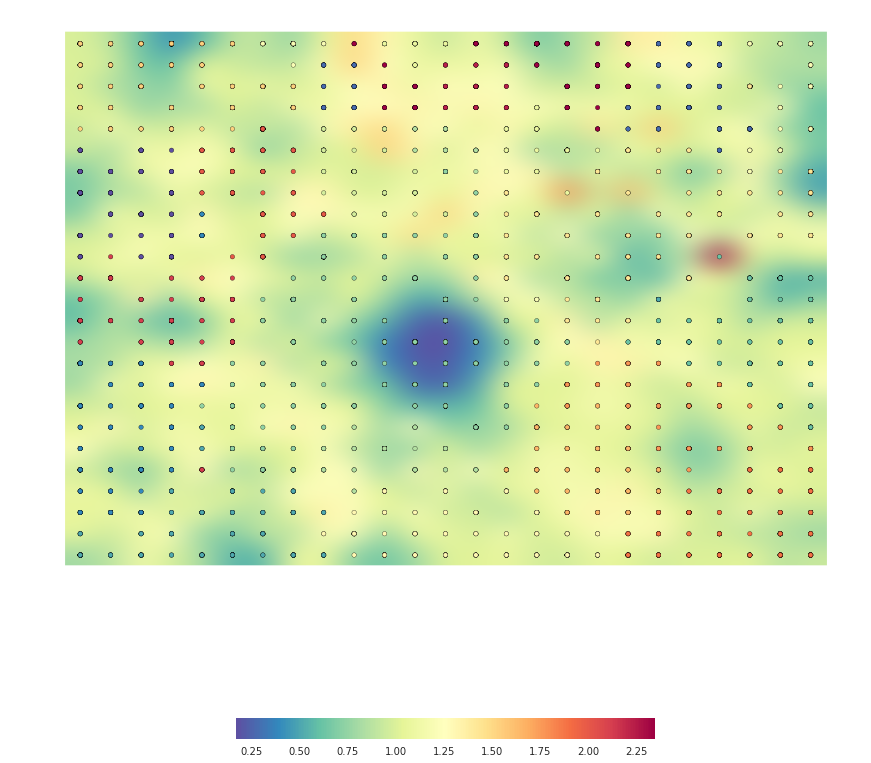

K-means with k=20


array([[12, 12, 12, 12, 12, 12,  9,  9,  9, 19,  8,  8,  8, 19, 19, 19, 19,
        19, 19,  1,  1,  1,  9,  9,  9],
       [12, 12, 12, 12, 12, 12,  9,  9,  1,  1, 19,  8, 18, 18, 18, 19, 19,
        19, 19,  1,  1,  1,  1,  9,  9],
       [12, 12, 12, 12, 12, 12, 12, 12,  1,  1, 19, 19, 18, 18, 18, 19, 19,
        19, 19,  1,  1,  1, 11,  9,  9],
       [12, 12, 12, 12, 12, 12, 12, 12,  1,  1, 19, 19, 18, 18, 18,  8, 19,
        19,  1,  1,  1,  1, 11,  9,  9],
       [12, 12, 12, 12, 12, 12, 16, 16,  7,  7,  7,  6,  6,  6,  8,  8,  8,
        19,  1,  1,  1,  1,  1,  9,  9],
       [ 0,  0,  0,  0, 16, 16, 16, 16,  7,  7,  7,  6,  6,  6,  8,  8,  8,
         8, 11, 11, 11,  1,  9,  9, 11],
       [ 0,  0,  0,  0, 16, 16, 16, 16,  7,  7,  7,  7,  5,  6,  8,  8,  8,
        11, 11, 11, 11, 11,  9, 11, 11],
       [ 0,  0,  0,  0, 16, 16, 16, 16,  7,  7,  7,  7,  7,  5, 11, 11,  8,
        11, 11, 11, 11, 11, 11, 11, 11],
       [ 0,  0,  0,  0,  2, 16, 16, 16, 16,  7,  7,  7,  7,  5, 

In [35]:
#Οπτικοποίηση Αποτελεσμάτων
som.view_umatrix(figsize=(15,15),colorbar=True,bestmatches=True)
print "K-means with k=20"
som.clusters

In [36]:
uniques,counts= np.unique(som.clusters,return_counts=True)
print "Cluster Index and Number of Neurons in this"
print np.argsort(counts)
print np.sort(counts)

Cluster Index and Number of Neurons in this
[18  8  7  9  6 19 13  0 16  1 14 17 15 10  3  2  4 12 11  5]
[ 9 16 19 21 22 23 24 24 25 26 28 28 29 31 32 32 33 34 70 99]


## Σημασιολογική ερμηνεία των clusters

Προκειμένου να μελετήσουμε τις τοπολογικές ιδιότητες του SOM και το αν έχουν ενσωματώσει σημασιολογική πληροφορία για τις ταινίες διαμέσου της διανυσματικής αναπαράστασης με το tf-idf και των κατηγοριών, χρειαζόμαστε ένα κριτήριο ποιοτικής επισκόπησης των clusters. Θα υλοποιήσουμε το εξής κριτήριο: Λαμβάνουμε όρισμα έναν αριθμό (ετικέτα) cluster. Για το cluster αυτό βρίσκουμε όλους τους νευρώνες που του έχουν ανατεθεί από τον k-Means. Για όλους τους νευρώνες αυτούς βρίσκουμε όλες τις ταινίες που τους έχουν ανατεθεί (για τις οποίες αποτελούν bmus). Για όλες αυτές τις ταινίες τυπώνουμε ταξινομημένη τη συνολική στατιστική όλων των ειδών (κατηγοριών) και τις συχνότητές τους. Αν το cluster διαθέτει καλή συνοχή και εξειδίκευση, θα πρέπει κάποιες κατηγορίες να έχουν σαφώς μεγαλύτερη συχνότητα από τις υπόλοιπες. Θα μπορούμε τότε να αναθέσουμε αυτήν/ές την/τις κατηγορία/ες ως ετικέτες στο cluster.

Μπορείτε να υλοποιήσετε τη συνάρτηση αυτή όπως θέλετε. Μια πιθανή διαδικασία θα μπορούσε να είναι η ακόλουθη:

1. Ορίζουμε συνάρτηση `print_categories_stats` που δέχεται ως είσοδο λίστα με ids ταινιών. Δημιουργούμε μια κενή λίστα συνολικών κατηγοριών. Στη συνέχεια, για κάθε ταινία επεξεργαζόμαστε το string `categories` ως εξής: δημιουργούμε μια λίστα διαχωρίζοντας το string κατάλληλα με την `split` και αφαιρούμε τα whitespaces μεταξύ ετικετών με την `strip`. Προσθέτουμε τη λίστα αυτή στη συνολική λίστα κατηγοριών με την `extend`. Τέλος χρησιμοποιούμε πάλι την `np.unique` για να μετρήσουμε συχνότητα μοναδικών ετικετών κατηγοριών και ταξινομούμε με την `np.argsort`. Τυπώνουμε τις κατηγορίες και τις συχνότητες εμφάνισης ταξινομημένα. Χρήσιμες μπορεί να σας φανούν και οι `np.ravel`, `np.nditer`, `np.array2string` και `zip`.

2. Ορίζουμε τη βασική μας συνάρτηση `print_cluster_neurons_movies_report` που δέχεται ως όρισμα τον αριθμό ενός cluster. Με τη χρήση της `np.where` μπορούμε να βρούμε τις συντεταγμένες των bmus που αντιστοιχούν στο cluster και με την `column_stack` να φτιάξουμε έναν πίνακα bmus για το cluster. Προσοχή στη σειρά (στήλη - σειρά) στον πίνακα bmus. Για κάθε bmu αυτού του πίνακα ελέγχουμε αν υπάρχει στον πίνακα μοναδικών bmus που έχουμε υπολογίσει στην αρχή συνολικά και αν ναι προσθέτουμε το αντίστοιχο index του νευρώνα σε μια λίστα. Χρήσιμες μπορεί να είναι και οι `np.rollaxis`, `np.append`, `np.asscalar`. Επίσης πιθανώς να πρέπει να υλοποιήσετε ένα κριτήριο ομοιότητας μεταξύ ενός bmu και ενός μοναδικού bmu από τον αρχικό πίνακα bmus.

3. Υλοποιούμε μια βοηθητική συνάρτηση `neuron_movies_report`. Λαμβάνει ένα σύνολο νευρώνων από την `print_cluster_neurons_movies_report` και μέσω της `indices` φτιάχνει μια λίστα με το σύνολο ταινιών που ανήκουν σε αυτούς τους νευρώνες. Στο τέλος καλεί με αυτή τη λίστα την `print_categories_stats` που τυπώνει τις στατιστικές.

Μπορείτε βέβαια να προσθέσετε οποιαδήποτε επιπλέον έξοδο σας βοηθάει. Μια χρήσιμη έξοδος είναι πόσοι νευρώνες ανήκουν στο cluster και σε πόσους και ποιους από αυτούς έχουν ανατεθεί ταινίες.

Θα επιτελούμε τη σημασιολογική ερμηνεία του χάρτη καλώντας την `print_cluster_neurons_movies_report` με τον αριθμός ενός cluster που μας ενδιαφέρει. 

In [37]:
#εδώ ορίζουμε τις συναρτήσεις για τη σημασιολογική ανάλυση του som

#δέχεται ως όρισμα μια λίστα με ταινίες και επιστρέφει μια λίστα με το σύνολο των κατηγοριών των ταινιών και το πλήθος τους
def print_categories_stats(movie_ids):
    #print movie_ids
    cats=[]
    for movie in movie_ids:
        my_cats=categories[movie][0]
        my_cats=''.join(my_cats.split())
        cat_str=my_cats.split(",")
        cats+=cat_str
    unique_cats,unique_cat_times=np.unique(cats,axis=0,return_counts=1)
    print "Unique Categories:"
    sorted_cats_args=np.argsort(unique_cat_times)
    sorted_cats_args=np.flip(sorted_cats_args,axis=0)

    #print unique_cat_times
    sorted_cats=[]
    for el in sorted_cats_args:
        sorted_cats.append((unique_cats[el],unique_cat_times[el]))
    print sorted_cats
    
def print_cluster_neurons_movies_report(cluster_id):
    # αρχικά βρίσκουμε τους νευρώνες που του έχουν ανατεθεί
    x_results,y_results=np.where(som.clusters==cluster_id)
    neurons=np.column_stack((x_results,y_results))
    ln=unique_bmus.shape[0]
    cluster_list=[]
    for n in neurons:
        for i in range(ln):
            if (unique_bmus[i][0]==n[0]):
                if (unique_bmus[i][1]==n[1]):
                    cluster_list.append(i)
    return cluster_list

#παιρνει ως όρισμα μια λίστα από indexes νευρώνων, βρίσκει τις ταινίες που ανήκουν σε αυτούς και καλεί την print_categories_stats για να τυπώσει τις κατηγορίες στις οποίες ανήκουν αυτές οι ταινίες
def neuron_movies_report(neurons_list):
    cluster_movies=[]
    for n_id in neurons_list:
        my_movies=[]
        for i in range(len(indices)):
            if (indices[i]==n_id):
                my_movies.append(i)
        cluster_movies+=my_movies
    #print '------------------------------------------------'
    print_categories_stats(cluster_movies)   

## Ανάλυση τοπολογικών ιδιοτήτων χάρτη SOM

Για τον τελικό χάρτη SOM που θα παράξετε για τη συλλογή σας, αναλύστε σε markdown με συγκεκριμένη αναφορά σε αριθμούς clusters και τη σημασιολογική ερμηνεία τους τις εξής τρεις τοπολογικές ιδιότητες του SOM: 

1. Δεδομένα που έχουν μεγαλύτερη πυκνότητα πιθανότητας στο χώρο εισόδου τείνουν να απεικονίζονται με περισσότερους νευρώνες στο χώρο μειωμένης διαστατικότητας. Δώστε παραδείγματα από συχνές και λιγότερο συχνές κατηγορίες ταινιών. Χρησιμοποιήστε τις στατιστικές των κατηγοριών στη συλλογή σας και τον αριθμό κόμβων που χαρακτηρίζουν.
2. Μακρινά πρότυπα εισόδου τείνουν να απεικονίζονται απομακρυσμένα στο χάρτη. Υπάρχουν χαρακτηριστικές κατηγορίες ταινιών που ήδη από μικρούς χάρτες τείνουν να τοποθετούνται σε διαφορετικά ή απομονωμένα σημεία του χάρτη.
3. Κοντινά πρότυπα εισόδου τείνουν να απεικονίζονται κοντά στο χάρτη. Σε μεγάλους χάρτες εντοπίστε είδη ταινιών και κοντινά τους υποείδη.

Προφανώς τοποθέτηση σε 2 διαστάσεις που να σέβεται μια απόλυτη τοπολογία δεν είναι εφικτή, αφενός γιατί δεν υπάρχει κάποια απόλυτη εξ ορισμού για τα κινηματογραφικά είδη ακόμα και σε πολλές διαστάσεις, αφετέρου γιατί πραγματοποιούμε μείωση διαστατικότητας.

Εντοπίστε μεγάλα clusters και μικρά clusters που δεν έχουν σαφή χαρακτηριστικά. Εντοπίστε clusters συγκεκριμένων ειδών που μοιάζουν να μην έχουν τοπολογική συνάφεια με γύρω περιοχές. Προτείνετε πιθανές ερμηνείες.

Τέλος, εντοπίστε clusters που έχουν κατά την άποψή σας ιδιαίτερο ενδιαφέρον στη συλλογή της ομάδας σας (data exploration / discovery value) και σχολιάστε.

Αρχικά επιλέγουμε δύο clusters που βρίσκονται τοπογραφικά κοντά μεταξύ τους και τυπώνουμε τα είδη των ταινιών από τις οποίες αποτελούνται. Παρατηρούμε ότι υπάρχει ομοιότητα στις κατηγορίες που περιέχονται στα δύο clusters.

In [38]:
neuron_movies_report(print_cluster_neurons_movies_report(8))
neuron_movies_report(print_cluster_neurons_movies_report(19))

Unique Categories:
[('"RomanceFilm"', 62), ('"Drama"', 61), ('"Musical"', 40), ('"Biographicalfilm"', 33), ('"Biography"', 29), ('"Periodpiece"', 18), ('"Comedyfilm"', 17), ('"Biopic[feature]"', 15), ('"Black-and-white"', 9), ('"Comedy"', 8), ('"Costumedrama"', 6), ('"MusicalDrama"', 5), ('"Music"', 5), ('"Romanticdrama"', 4), ('"CrimeFiction"', 3), ('"CourtroomDrama"', 3), ('"Christianfilm"', 3), ('"Indie"', 3), ('"Filmadaptation"', 3), ('"Roadshowtheatricalrelease"', 2), ('"Hagiography"', 2), ('"Dance"', 2), ('"Documentary"', 2), ('"Televisionmovie"', 2), ('"Epic"', 2), ('"FamilyFilm"', 2), ('"Adventure"', 2), ('"Warfilm"', 2), ('"Romanticcomedy"', 2), ('"History"', 2), ('"Americana"', 2), ('"Sports"', 2), ('"Musicalcomedy"', 2), ('"Comingofage"', 1), ('"Worldcinema"', 1), ('"Historicaldrama"', 1), ('"CrimeDrama"', 1), ('"HistoricalEpic"', 1), ('"Historicalfiction"', 1), ('"Horror"', 1), ('"InspirationalDrama"', 1), ('"JapaneseMovies"', 1), ('"Melodrama"', 1), ('"Propagandafilm"', 1)

Αυτό όμως δε συμβαίνει για όλα τα γειτονικά clusters.

Έπειτα, επιλέγουμε clusters που βρίσκονται τοπογραφικά μακριά στο χάρτη som και τυπώνουμε τις κατηγορίες των ταινιών που περιέχουν. Βλέπουμε ότι σε αυτή την περίπτωση υπάρχουν λιγότερες κοινές κατηγορίες στα 2 clusters.

In [41]:
neuron_movies_report(print_cluster_neurons_movies_report(18))
neuron_movies_report(print_cluster_neurons_movies_report(13))

Unique Categories:
[('"RomanceFilm"', 89), ('"Drama"', 82), ('"Fantasy"', 6), ('"FamilyFilm"', 5), ('"JapaneseMovies"', 4), ('"ChineseMovies"', 4), ('"Silentfilm"', 4), ('"Action"', 3), ('"Adventure"', 3), ('"Teen"', 3), ('"CrimeFiction"', 2), ('"Filmadaptation"', 2), ('"Historicalfiction"', 2), ('"Televisionmovie"', 2), ('"Thriller"', 2), ('"Tragicomedy"', 1), ('"Melodrama"', 1), ('"Politicaldrama"', 1), ('"ReligiousFilm"', 1), ('"Eroticthriller"', 1), ('"EroticDrama"', 1), ('"Roadmovie"', 1), ('"ShortFilm"', 1), ('"Comedy-drama"', 1), ('"Anime"', 1), ('"Animation"', 1), ('"Western"', 1)]
Unique Categories:
[('"Thriller"', 129), ('"Horror"', 111), ('"Slasher"', 39), ('"Worldcinema"', 38), ('"Mystery"', 26), ('"Supernatural"', 25), ('"Psychologicalthriller"', 22), ('"Teen"', 21), ('"Indie"', 12), ('"JapaneseMovies"', 10), ('"Fantasy"', 8), ('"B-movie"', 8), ('"Suspense"', 8), ('"ScienceFiction"', 7), ('"Comedy"', 6), ('"CrimeThriller"', 6), ('"Cult"', 6), ('"Black-and-white"', 6), ('"C

Στη συνέχεια, θα προσπαθήσουμε να δώσουμε ορισμένα παραδείγματα από συχνές και λιγότερο συχνές κατηγορίες ταινιών. Για το σκοπό αυτό θα χρησιμοποιήσουμε τη λογική των βοηθητικών συναρτήσεων που ορίσαμε προηγουμένως για να μπορούμε τελικά να βρούμε τον αριθμό των νευρώνων στους οποίους απεικονίζεται μια κατηγορία ταινιών:

In [82]:
def neuronhascategory(n,cat):
    #ο n είναι ένας νευρώνας και μας ενδιαφέρει να ανακαλύψουμε αν η κατηγορία cat έχει απεικονισθεί στον n
    #βρίσκουμε αρχικά από ποιες ταινίες αποτελείται ο n
    my_movies=[]
    for i in range(len(indices)):
        if (indices[i]==n):
            my_movies.append(i)
    for m in my_movies:
        my_cats=categories[m][0]
        my_cats=''.join(my_cats.split())
        cat_str=my_cats.split(",")
        #print cat_str
        for i in range(len(cat_str)):
            if (cat_str[i]==cat):
                return 1
    return 0

def clusterhascategory(cl,cat):
    #θέλουμε να βρούμε το πλήθος των νευρώνων του cluster cl στους οποίους περιέχεται η κατηγορία cat
    my_neurons=print_cluster_neurons_movies_report(cl)
    #print len(my_neurons)
    counter=0
    for n in my_neurons:
        if (neuronhascategory(n,cat)==1):
            counter+=1
    return counter

def totalneurons(cat):
    #επιστρέφει το πλήθος των νευρώνων στους οποίους εμφανίζεται η κατηγορία cat(σύνολο 535 bmus)
    total_cnt=0
    for cl in uniques:
        total_cnt+=clusterhascategory(cl,cat)
    print "(",cat,total_cnt,")"

Εάν καλέσουμε τη συνάρτηση totalneurons για κατηγορίες με μεγάλη συχνότητα εμφάνισης στα δεδομένα εισόδου(πχ Drama,Thriller) βλέπουμε ότι απεικονίζονται σε έναν μεγάλο αριθμό νευρώνων, ενώ ταινίες με μικρή συχνότητα εμφάνισης στα δεδομένα εισόδου(πχ Docudrama,DomesticComedy) δεν εμφανίζονται σε τόσο πολλούς νευρώνες

In [84]:
totalneurons('"Drama"')
totalneurons('"Thriller"')
totalneurons('"Docudrama"')
totalneurons('"DomesticComedy"')

( "Drama" 299 )
( "Thriller" 146 )
( "Docudrama" 15 )
( "DomesticComedy" 10 )


Τα μεγέθη των clusters ποικίλουν, καθώς και το πόσο ομοιογενή είναι ή πόσο σαφή είναι τα χαρακτηριστικά τους. Για παράδειγμα, το cluster no.3 έχει 32 νευρώνες και το περιεχόμενό του δεν έχει μεγάλη συνοχή, σε αντίθεση με το cluster 13 που είναι μικρότερο(24 νευρώνες) και έχει μεγαλύτερη συνοχή.

In [101]:
print "Cluster No.3"
neuron_movies_report(print_cluster_neurons_movies_report(3))
print "\nCluster No.13"
neuron_movies_report(print_cluster_neurons_movies_report(13))

Cluster No.3
Unique Categories:
[('"ShortFilm"', 183), ('"Documentary"', 106), ('"Animation"', 98), ('"FamilyFilm"', 71), ('"Comedyfilm"', 53), ('"CrimeFiction"', 28), ('"Fantasy"', 14), ('"Musical"', 14), ('"Drama"', 13), ('"Action"', 12), ('"Music"', 11), ('"Thriller"', 11), ('"Adventure"', 8), ('"ScienceFiction"', 6), ('"Indie"', 6), ('"Costumedrama"', 5), ('"Children\'s/Family"', 5), ('"Action/Adventure"', 4), ('"Sports"', 4), ('"Children\'s"', 4), ('"ComputerAnimation"', 4), ('"Western"', 3), ('"Swordandsorcery"', 3), ('"Black-and-white"', 3), ('"Warfilm"', 3), ('"Horror"', 3), ('"Biography"', 3), ('"RomanceFilm"', 3), ('"Rockumentary"', 3), ('"Silentfilm"', 3), ('"Propagandafilm"', 3), ('"Periodpiece"', 3), ('"Animatedcartoon"', 3), ('"History"', 2), ('"ChineseMovies"', 2), ('"CrimeThriller"', 2), ('"Stopmotion"', 2), ('"HolidayFilm"', 2), ('"Mystery"', 2), ('"Anime"', 2), ('"JapaneseMovies"', 2), ('"Biographicalfilm"', 2), ('"CostumeAdventure"', 2), ('"Historicalfiction"', 2), (

In [122]:
joblib.dump(som, 'som.pkl')
!cp corpus_tf_idf.pkl /gpfs/fs01/user/s653-bbdcd845a65a2b-8dae92f2c105/data/
!cp som.pkl /gpfs/fs01/user/s653-bbdcd845a65a2b-8dae92f2c105/data/